# Predicting mental health consequencies using K nearest neighbor, Support vector classification and Decision trees

## Mental Health Survey Dataset: https://www.kaggle.com/osmi/mental-health-in-tech-survey

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
survey_df = pd.read_csv('survey.csv')
survey_df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
survey_df.shape

(1259, 27)

## 1.	Create a statistical summary of the data set.

In [4]:
survey_df.describe(include='O').transpose()

,count,unique,top,freq
Timestamp,1259,1246,2014-08-27 15:55:07,2
Gender,1259,49,Male,615
Country,1259,48,United States,751
state,744,45,CA,138
self_employed,1241,2,No,1095
family_history,1259,2,No,767
treatment,1259,2,Yes,637
work_interfere,995,4,Sometimes,465
no_employees,1259,6,6-25,290
remote_work,1259,2,No,883


In [5]:
#The columns considered irrelevant for the study were discarded (Timestamp, comments, State)
survey_df.drop(['Timestamp', 'comments','state'], axis=1, inplace=True)
survey_df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
#checking for any missing values in the dataset
survey_df.isnull().sum()

Age                            0
Gender                         0
Country                        0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [7]:
for col in survey_df.columns:
    print('Unique enteries for ' + col + ' are :\n') 
    print(survey_df[col].unique(),'\n')

Unique enteries for Age are :

[         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72] 

Unique enteries for Gender are :

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'

In [8]:
# The rows for age less than 16 years and more than 130 years were discarded, these entries accounted 
# for only 0.63% of the rows in dataset.

100*(survey_df[survey_df['Age'] < 16]['Age'].count() + survey_df[survey_df['Age'] >130]['Age'].count())/survey_df['Age'].count()

0.6354249404289118

In [9]:
survey_reduced = survey_df[(survey_df.Age <= 130) & (survey_df.Age >= 16)]
survey_reduced.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [10]:
survey_reduced.shape

(1251, 24)

In [11]:
#filled the missing values for self_employed feature with mode 'No' (frequency: 1095, total enteries: 1241)

survey_reduced['self_employed'] = survey_reduced['self_employed'].fillna(survey_reduced['self_employed'].mode()[0])
survey_reduced.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,No,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [12]:
survey_reduced['self_employed'].unique()

array(['No', 'Yes'], dtype=object)

In [13]:
# Filling missing values of work interfere with 'don't know' 

survey_reduced['work_interfere'] = survey_reduced['work_interfere'].fillna('Don\'t know')

In [14]:
survey_reduced['work_interfere'].unique()

array(['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
      dtype=object)

In [15]:
survey_reduced['Gender'] = survey_reduced['Gender'].str.lower()

In [16]:
survey_reduced['Gender'].unique()

array(['female', 'm', 'male', 'male-ish', 'maile', 'trans-female',
       'cis female', 'f', 'something kinda male?', 'cis male', 'woman',
       'mal', 'male (cis)', 'queer/she/they', 'non-binary', 'femake',
       'make', 'nah', 'enby', 'fluid', 'genderqueer', 'female ',
       'androgyne', 'agender', 'cis-female/femme', 'guy (-ish) ^_^',
       'male leaning androgynous', 'male ', 'man', 'trans woman', 'msle',
       'neuter', 'female (trans)', 'queer', 'female (cis)', 'mail',
       'malr', 'femail', 'cis man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [17]:
# Gender feature unique values reduced by merging existing enteries into three major categories: 'male', 'female', and 'other'  

male_list = ['m', 'male', 'male-ish', 'maile', 'cis male', 'mal', 'male (cis)', 'make', 'male ', 'man', 'msle', 'mail'
             , 'malr', 'cis man']
female_list = ['female', 'cis female', 'f', 'woman', 'femake', 'female ', 'cis-female/femme', 'female (cis)', 'femail']

conditions = [
    (survey_reduced['Gender'].isin(male_list)),
    (survey_reduced['Gender'].isin(female_list))
]

choices = ['male', 'female']
survey_reduced['Gender'] = np.select(conditions, choices, default='other')

survey_reduced['Gender'].unique()

array(['female', 'male', 'other'], dtype=object)

In [18]:
survey_reduced.groupby(['mental_health_consequence'])['mental_health_consequence'].count()

mental_health_consequence
Maybe    476
No       487
Yes      288
Name: mental_health_consequence, dtype: int64

In [19]:
# Since we are predicting mental health consequences we will eliminate 'Maybe' enteries.  

survey_reduced = survey_reduced[(survey_reduced.mental_health_consequence == 'Yes') | (survey_reduced.mental_health_consequence == 'No')]

In [20]:
survey_reduced.groupby(['mental_health_consequence'])['mental_health_consequence'].count()

mental_health_consequence
No     487
Yes    288
Name: mental_health_consequence, dtype: int64

Text(0.5, 0, 'Age')

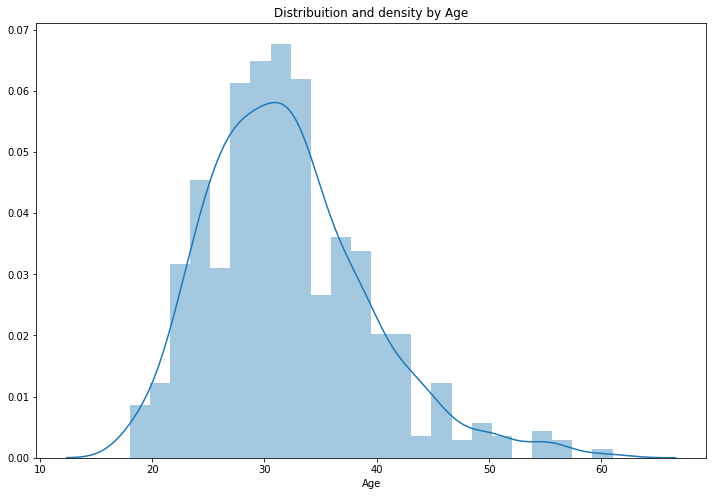

In [21]:
# Distribiution and density by Age

plt.figure(figsize=(12,8))
sns.distplot(survey_reduced['Age'], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

In [22]:
# Stratifying the Age data

survey_reduced['Age_range'] = pd.cut(survey_reduced['Age'], bins=[16,25,30,35,40,np.inf], labels=[1,2,3,4,5])

Text(0, 0.5, 'Number of people')

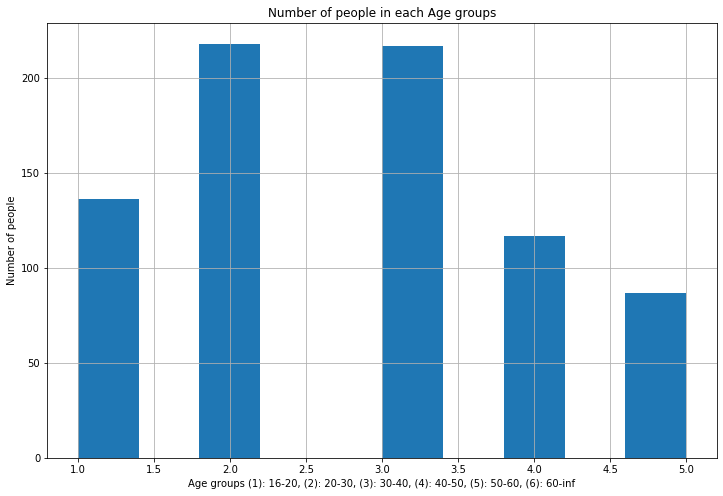

In [23]:
plt.figure(figsize=(12,8))
survey_reduced['Age_range'].hist()
plt.title('Number of people in each Age groups')
plt.xlabel('Age groups (1): 16-20, (2): 20-30, (3): 30-40, (4): 40-50, (5): 50-60, (6): 60-inf')
plt.ylabel('Number of people')

In [24]:
survey = survey_reduced.reset_index(drop=True)

In [25]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 25 columns):
Age                          775 non-null int64
Gender                       775 non-null object
Country                      775 non-null object
self_employed                775 non-null object
family_history               775 non-null object
treatment                    775 non-null object
work_interfere               775 non-null object
no_employees                 775 non-null object
remote_work                  775 non-null object
tech_company                 775 non-null object
benefits                     775 non-null object
care_options                 775 non-null object
wellness_program             775 non-null object
seek_help                    775 non-null object
anonymity                    775 non-null object
leave                        775 non-null object
mental_health_consequence    775 non-null object
phys_health_consequence      775 non-null object
coworkers     

In [26]:
"""Chi-Square test to perform hypothesis testing, if a categorical feature has relationship with 
the categorical output to be predicted"""

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX) 
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)
        
        print('p_value: %.8f, \n' % p)
        
        return p

In [27]:
#Initialize ChiSquare Class
cT = ChiSquare(survey)

#Feature Selection
testColumns = list(survey.columns)
testColumns.remove('Age')
testColumns.remove('mental_health_consequence')

p_values = []

for var in testColumns:
    p_values.append(cT.TestIndependence(colX=var,colY="mental_health_consequence"))
    
chi2_results =pd.DataFrame(list(zip(testColumns,p_values)), columns = ['Feature', 'P-value'])    

Gender is IMPORTANT for Prediction
p_value: 0.00073836, 

Country is IMPORTANT for Prediction
p_value: 0.02233833, 

self_employed is NOT an important predictor. (Discard self_employed from model)
p_value: 0.06488800, 

family_history is IMPORTANT for Prediction
p_value: 0.00170803, 

treatment is IMPORTANT for Prediction
p_value: 0.00002597, 

work_interfere is IMPORTANT for Prediction
p_value: 0.00000000, 

no_employees is IMPORTANT for Prediction
p_value: 0.01414028, 

remote_work is NOT an important predictor. (Discard remote_work from model)
p_value: 0.96330650, 

tech_company is IMPORTANT for Prediction
p_value: 0.00011821, 

benefits is IMPORTANT for Prediction
p_value: 0.00601559, 

care_options is IMPORTANT for Prediction
p_value: 0.02838137, 

wellness_program is IMPORTANT for Prediction
p_value: 0.00000004, 

seek_help is IMPORTANT for Prediction
p_value: 0.00002932, 

anonymity is IMPORTANT for Prediction
p_value: 0.00000000, 

leave is IMPORTANT for Prediction
p_value: 0.0

In [28]:
# Sorted values by lower p-values and selected the top 10 features

chi2_results.sort_values(by=['P-value'])

,Feature,P-value
17,supervisor,3.346153e-83
15,phys_health_consequence,1.181979e-71
16,coworkers,2.578358e-48
20,mental_vs_physical,1.776196e-46
14,leave,8.159150e-33
18,mental_health_interview,6.351698e-24
13,anonymity,2.873269e-16
21,obs_consequence,2.859995e-15
5,work_interfere,1.646953e-10
11,wellness_program,3.691941e-08


In [29]:
survey = survey[['supervisor', 'phys_health_consequence', 'coworkers', 'mental_vs_physical', 'leave', 'mental_health_interview',
                        'anonymity', 'obs_consequence', 'work_interfere', 'wellness_program', 'Age_range', 'mental_health_consequence']]

## 2.	Feature analysis

Text(0, 0.5, 'Number of responses')

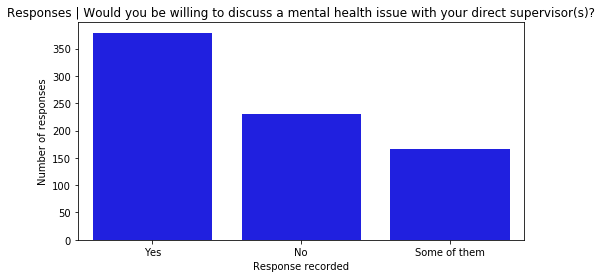

In [30]:
plt.figure(figsize=(8,4))
sns.countplot(survey['supervisor'], color='blue')
plt.title('Responses | Would you be willing to discuss a mental health issue with your direct supervisor(s)?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

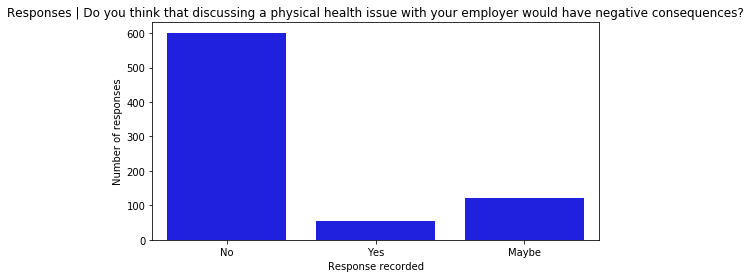

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(survey['phys_health_consequence'], color='blue')
plt.title('Responses | Do you think that discussing a physical health issue with your employer would have negative consequences?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

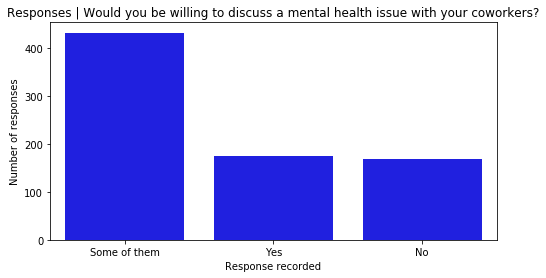

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(survey['coworkers'], color='blue')
plt.title('Responses | Would you be willing to discuss a mental health issue with your coworkers?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

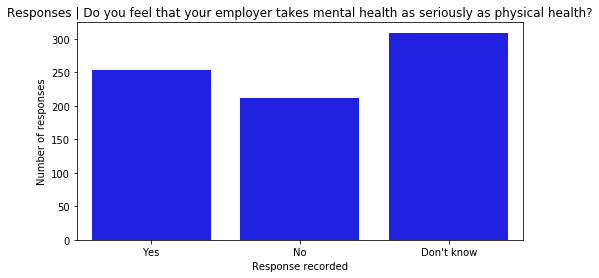

In [33]:
plt.figure(figsize=(8,4))
sns.countplot(survey['mental_vs_physical'], color='blue')
plt.title('Responses | Do you feel that your employer takes mental health as seriously as physical health?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

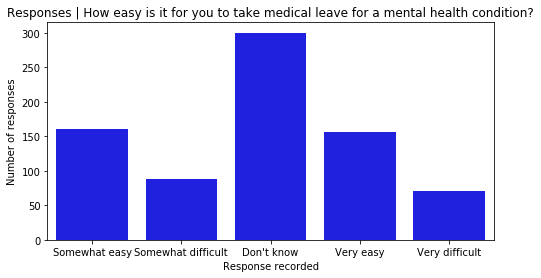

In [34]:
plt.figure(figsize=(8,4))
sns.countplot(survey['leave'], color='blue')
plt.title('Responses | How easy is it for you to take medical leave for a mental health condition?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

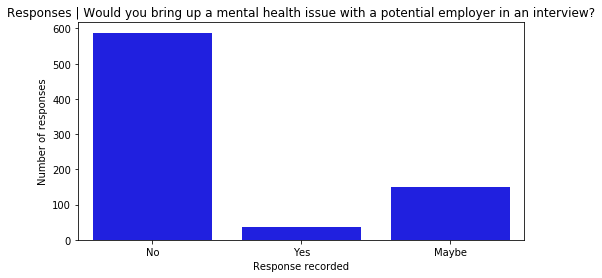

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(survey['mental_health_interview'], color='blue')
plt.title('Responses | Would you bring up a mental health issue with a potential employer in an interview?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

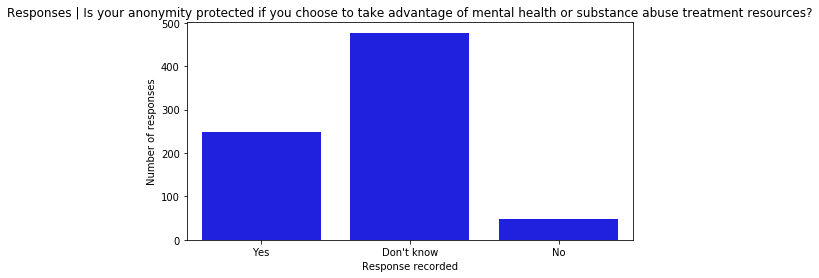

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(survey['anonymity'], color='blue')
plt.title('Responses | Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

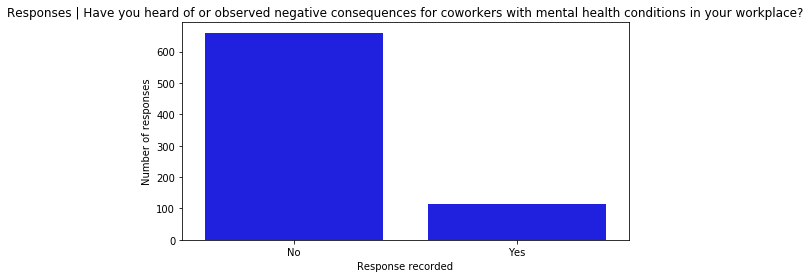

In [37]:
plt.figure(figsize=(8,4))
sns.countplot(survey['obs_consequence'], color='blue')
plt.title('Responses | Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

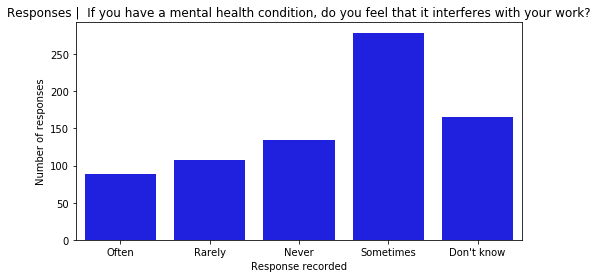

In [38]:
plt.figure(figsize=(8,4))
sns.countplot(survey['work_interfere'], color='blue')
plt.title('Responses |  If you have a mental health condition, do you feel that it interferes with your work?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

Text(0, 0.5, 'Number of responses')

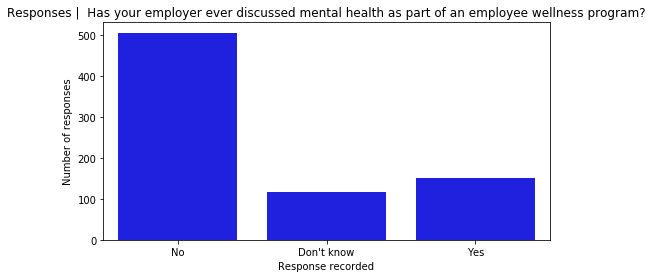

In [39]:
plt.figure(figsize=(8,4))
sns.countplot(survey['wellness_program'], color='blue')
plt.title('Responses |  Has your employer ever discussed mental health as part of an employee wellness program?')
plt.xlabel('Response recorded')
plt.ylabel('Number of responses')

In [40]:
le = LabelEncoder()
survey['mental_health_consequence'] = le.fit_transform(survey['mental_health_consequence'])    

In [41]:
# Stratified sampling to ensure each age group is represented in our training and testing datasets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(survey, survey['Age_range']):
    strat_train_set = survey.loc[train_index]
    strat_test_set = survey.loc[test_index]
    
strat_test_set['Age_range'].value_counts() / len(strat_test_set)

2    0.283871
3    0.277419
1    0.174194
4    0.148387
5    0.116129
Name: Age_range, dtype: float64

In [42]:
strat_train_set

,supervisor,phys_health_consequence,coworkers,mental_vs_physical,leave,mental_health_interview,anonymity,obs_consequence,work_interfere,wellness_program,Age_range,mental_health_consequence
219,Yes,No,Some of them,Don't know,Don't know,No,Yes,No,Sometimes,No,1,0
748,Yes,No,Some of them,Don't know,Don't know,No,Don't know,No,Rarely,No,2,0
349,Some of them,No,Some of them,Don't know,Don't know,No,Don't know,No,Rarely,No,4,0
120,No,No,Some of them,Yes,Somewhat easy,No,Don't know,No,Don't know,No,2,0
300,No,No,No,Don't know,Very easy,No,Don't know,No,Don't know,No,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
226,Some of them,Yes,Some of them,Don't know,Somewhat easy,No,Don't know,No,Sometimes,No,3,1
261,Yes,No,Some of them,No,Don't know,Maybe,Don't know,No,Don't know,No,1,0
571,Yes,No,Yes,Don't know,Very easy,No,Don't know,No,Often,No,1,0
744,Yes,No,Some of them,Don't know,Somewhat easy,No,Don't know,No,Sometimes,No,3,0


In [43]:
cat_encoder = OneHotEncoder()
X_train =  cat_encoder.fit_transform(strat_train_set.drop('mental_health_consequence', axis = 1))

In [44]:
y_train = strat_train_set['mental_health_consequence'].copy()

In [45]:
cat_encoder = OneHotEncoder()
X_test =  cat_encoder.fit_transform(strat_test_set.drop('mental_health_consequence', axis = 1))

In [46]:
y_test = strat_test_set['mental_health_consequence'].copy()

## 3.	Analyze the data using  Machine Learning Algorithms to predict Mental Health Consequences.

### Model 1: Support Vector Classification (SVC)

In [47]:
from sklearn.svm import SVC 

param_grid_svm = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 'kernel': ['linear']}

svm_Linear = SVC()

grid_search_svm = GridSearchCV(svm_Linear , param_grid = param_grid_svm, cv=3, scoring = 'accuracy',return_train_score=True)

grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [48]:
print(grid_search_svm.best_params_)

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


In [49]:
print(grid_search_svm.best_estimator_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [50]:
print('Best training accuracy score for SVC is: ', grid_search_svm.cv_results_['mean_train_score'][grid_search_svm.best_index_])

Best training accuracy score for SVC is:  0.9266020980879571


In [51]:
y_predict_svm = grid_search_svm.predict(X_test)

In [52]:
print('Predictions:', le.inverse_transform(y_predict_svm[:5]))

Predictions: ['No' 'Yes' 'Yes' 'No' 'No']


In [53]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['No' 'Yes' 'Yes' 'No' 'No']


In [54]:
cm_svm = confusion_matrix(y_test,y_predict_svm)
                          
print(confusion_matrix(y_test,y_predict_svm))

[[90  6]
 [10 49]]


(2.0, 0.0)

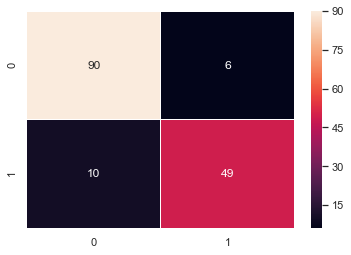

In [55]:
sns.set()
ax=sns.heatmap(cm_svm, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [56]:
print(classification_report(y_test,y_predict_svm,target_names = ['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.90      0.94      0.92        96
         Yes       0.89      0.83      0.86        59

    accuracy                           0.90       155
   macro avg       0.90      0.88      0.89       155
weighted avg       0.90      0.90      0.90       155



In [57]:
print('Testing Accuracy Score for SVM is:', round(accuracy_score(y_test, y_predict_svm, normalize=True),4))

Testing Accuracy Score for SVM is: 0.8968


In [58]:
scores_svm = cross_val_score(grid_search_svm,X_train,y_train,scoring='accuracy',cv=10)
error_svm = [round(1-x,4) for x in scores_svm]

In [59]:
error_svm

[0.0794,
 0.0484,
 0.1129,
 0.0645,
 0.0968,
 0.0645,
 0.0323,
 0.0968,
 0.1129,
 0.1311]

### Model 2: K Nearest Neighbor 

In [60]:
from sklearn.neighbors import KNeighborsClassifier 

param_grid_knn = {'n_neighbors': [10, 20, 30],  
              'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid = param_grid_knn, cv=3, scoring = 'accuracy',return_train_score=True)

grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [10, 20, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [61]:
print(grid_search_knn.best_params_)

{'n_neighbors': 20, 'weights': 'uniform'}


In [62]:
print(grid_search_knn.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')


In [63]:
print('Best training accuracy score for KNN is: ', grid_search_knn.cv_results_['mean_train_score'][grid_search_knn.best_index_])

Best training accuracy score for KNN is:  0.8951542297890969


In [64]:
y_predict_knn = grid_search_knn.predict(X_test)

In [65]:
print('Predictions:', le.inverse_transform(y_predict_knn[:5]))

Predictions: ['No' 'Yes' 'Yes' 'No' 'No']


In [66]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['No' 'Yes' 'Yes' 'No' 'No']


In [67]:
cm_knn = confusion_matrix(y_test,y_predict_knn)

print(confusion_matrix(y_test,y_predict_knn))

[[92  4]
 [11 48]]


(2.0, 0.0)

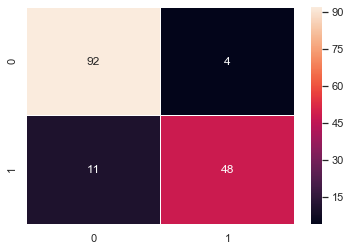

In [68]:
sns.set()
ax=sns.heatmap(cm_knn, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [69]:
print(classification_report(y_test,y_predict_knn,target_names = ['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.89      0.96      0.92        96
         Yes       0.92      0.81      0.86        59

    accuracy                           0.90       155
   macro avg       0.91      0.89      0.89       155
weighted avg       0.90      0.90      0.90       155



In [70]:
print('Testing Accuracy Score for KNN is:', round(accuracy_score(y_test, y_predict_knn, normalize=True),4))

Testing Accuracy Score for KNN is: 0.9032


In [71]:
scores_knn = cross_val_score(grid_search_knn,X_train,y_train,scoring='accuracy',cv=10)
error_knn = [round(1-x,4) for x in scores_knn]

In [72]:
error_knn

[0.0476, 0.0968, 0.1452, 0.1452, 0.129, 0.1129, 0.0806, 0.129, 0.1613, 0.1803]

### Model 3: Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier 

param_grid_dt = {'max_leaf_nodes': [5, 20, 30], 'min_samples_split': [2, 3, 4]}

dt = DecisionTreeClassifier(random_state= 42)

grid_search_dt = GridSearchCV(dt , param_grid = param_grid_dt, cv=3, scoring = 'accuracy',return_train_score=True)

grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': [5, 20, 30],
                         'min_samples_split': [2, 3, 4]},
             pre_dispatc

In [74]:
print(grid_search_dt.best_params_)

{'max_leaf_nodes': 5, 'min_samples_split': 2}


In [75]:
print(grid_search_dt.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


In [76]:
print('Best training accuracy score for Decision Tree is: ', grid_search_dt.cv_results_['mean_train_score'][grid_search_dt.best_index_])

Best training accuracy score for Decision Tree is:  0.899179994684427


In [77]:
y_predict_dt = grid_search_dt.predict(X_test)

In [78]:
print('Predictions:', le.inverse_transform(y_predict_dt[:5]))

Predictions: ['No' 'Yes' 'Yes' 'No' 'No']


In [79]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['No' 'Yes' 'Yes' 'No' 'No']


In [80]:
cm_dt = confusion_matrix(y_test,y_predict_dt)

print(confusion_matrix(y_test,y_predict_dt))

[[87  9]
 [13 46]]


(2.0, 0.0)

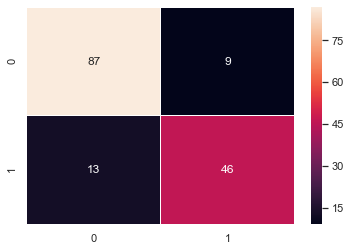

In [81]:
sns.set()
ax=sns.heatmap(cm_dt, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [82]:
print(classification_report(y_test,y_predict_dt,target_names = ['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.87      0.91      0.89        96
         Yes       0.84      0.78      0.81        59

    accuracy                           0.86       155
   macro avg       0.85      0.84      0.85       155
weighted avg       0.86      0.86      0.86       155



In [83]:
print('Testing Accuracy Score for Decision Tree is:', round(accuracy_score(y_test, y_predict_dt, normalize=True),4))

Testing Accuracy Score for Decision Tree is: 0.8581


In [84]:
scores_dt = cross_val_score(grid_search_dt,X_train,y_train,scoring='accuracy',cv=10)
error_dt = [round(1-x,4) for x in scores_dt]

In [85]:
error_dt

[0.0635, 0.0968, 0.1452, 0.0968, 0.1452, 0.0968, 0.0645, 0.129, 0.129, 0.1639]

## 4.	Compare the error from the three ML Algorithms tested.

In [86]:
prediction_errors = [error_svm, error_knn, error_dt]

[Text(0, 0, 'SVC'), Text(0, 0, 'KNN'), Text(0, 0, 'Decision Tree')]

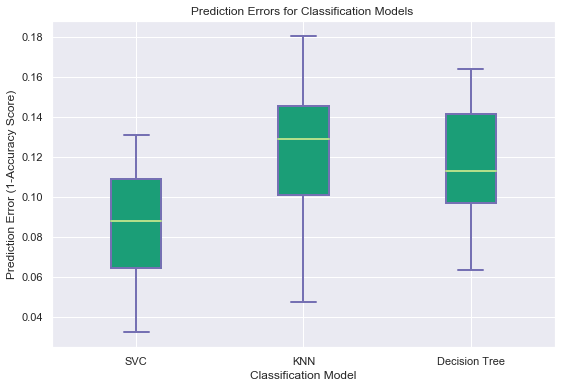

In [87]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(prediction_errors, patch_artist=True)

for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
    
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.title('Prediction Errors for Classification Models ')
plt.ylabel('Prediction Error (1-Accuracy Score)')
plt.xlabel('Classification Model')
ax.set_xticklabels(['SVC', 'KNN', 'Decision Tree'])

## 5.	Summary results table showing the accuracy score, confusion matrix, and classification report for the methods compared.

In [88]:
summ  = []

confusion_matrices = [cm_svm, cm_knn, cm_dt]
models = ['Support Vector Classification', 'K Nearest Neighbor', 'Decision Tree']

for i in range(len(models)):
    summ.append((models[i],(confusion_matrices[i][0][0]),
                    (confusion_matrices[i][1][0]), (confusion_matrices[i][1][1]), (confusion_matrices[i][0][1])))

summary_results = pd.DataFrame(summ, columns=['Model','True_Negative', 'False_Negative', 'True_Positive', 'False_Positive'])

summary_results['Recall'] = round(summary_results['True_Positive']/(summary_results['False_Negative']+summary_results['True_Positive']),4)
summary_results['Precision'] = round(summary_results['True_Positive']/(summary_results['False_Positive']+summary_results['True_Positive']),4)
summary_results['F-1 Score'] = round(2*summary_results['True_Positive']/(summary_results['False_Negative']+summary_results['False_Positive']+2*summary_results['True_Positive']),4)
summary_results['Testing Accuracy'] = [round(accuracy_score(y_test, y_predict_svm, normalize=True),4), round(accuracy_score(y_test, y_predict_knn, normalize=True),4), round(accuracy_score(y_test, y_predict_dt, normalize=True),4)]

In [89]:
summary_results

,Model,True_Negative,False_Negative,True_Positive,False_Positive,Recall,Precision,F-1 Score,Testing Accuracy
0,Support Vector Classification,90,10,49,6,0.8305,0.8909,0.8596,0.8968
1,K Nearest Neighbor,92,11,48,4,0.8136,0.9231,0.8649,0.9032
2,Decision Tree,87,13,46,9,0.7797,0.8364,0.8070,0.8581


## 6.	Choosing the “best” ML algorithm from #5, perform a sensitivity analysis on the effects of training % vs. testing %.

# Selected Support Vector Classification

In [90]:
svm_Linear = SVC()

grid_search_svm = GridSearchCV(svm_Linear , param_grid = param_grid_svm, cv=3, scoring = 'accuracy',return_train_score=True)

grid_search_svm.fit(X_train, y_train)

size_list = []
recall_list = []
accuracy_list = [] ##

for size in np.linspace(0.1, 0.9, 9):
    size_list.append(size)
    split = StratifiedShuffleSplit(n_splits=1, test_size = size, random_state=42)
    for train_index, test_index in split.split(survey, survey['Age_range']):
        strat_train_set = survey.loc[train_index]
        strat_test_set = survey.loc[test_index]
    X_train =  cat_encoder.fit_transform(strat_train_set.drop('mental_health_consequence', axis = 1))
    y_train = strat_train_set['mental_health_consequence'].copy()
    X_test =  cat_encoder.fit_transform(strat_test_set.drop('mental_health_consequence', axis = 1))
    y_test = strat_test_set['mental_health_consequence'].copy()
    grid_search_svm.fit(X_train, y_train)
    y_predict = grid_search_svm.predict(X_test)
    cm = confusion_matrix(y_test,y_predict)
    recall_list.append((cm[1][1])/(cm[1][0]+cm[1][1]))
    accuracy_list.append(round(accuracy_score(y_test, y_predict, normalize=True),4)) ##
    
Sen_Analysis = pd.DataFrame()
Sen_Analysis['Test Size'] = size_list
Sen_Analysis['Recall'] = recall_list
Sen_Analysis['Accuracy'] = accuracy_list
Sen_Analysis

C:\Users\Vishal Badyal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Test Size,Recall,Accuracy
0,0.1,0.814815,0.8590
1,0.2,0.830508,0.8968
2,0.3,0.829787,0.8712
3,0.4,0.854839,0.9065
4,0.5,0.815789,0.8866
5,0.6,0.849162,0.9054
6,0.7,0.857143,0.9042
7,0.8,0.844156,0.9065
8,0.9,0.863813,0.8983


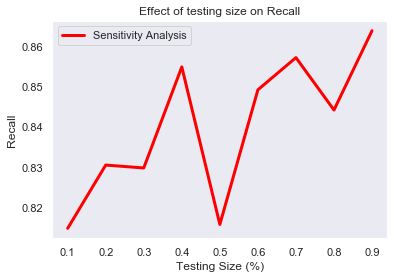

In [91]:
plt.plot(size_list, recall_list, color = 'red', label = 'Sensitivity Analysis', linewidth = 3)
plt.title('Effect of testing size on Recall')
plt.xlabel('Testing Size (%)')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

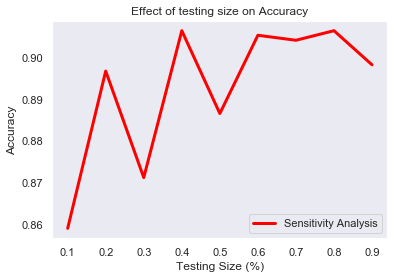

In [92]:
plt.plot(size_list, accuracy_list, color = 'red', label = 'Sensitivity Analysis', linewidth = 3)
plt.title('Effect of testing size on Accuracy')
plt.xlabel('Testing Size (%)')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## 7.	Randomly create 10 instances based on the features used in the model, then use the model to predict Mental Health Consequence using the best ML algorithm obtained from #5.

In [93]:
random_instance = np.random.choice([0, 1], size=(10,38), p=[.5, .5])
random_predict = grid_search_svm.predict(random_instance)

In [94]:
le.inverse_transform(random_predict).reshape(-1,1)

array([['Yes'],
       ['Yes'],
       ['Yes'],
       ['No'],
       ['Yes'],
       ['Yes'],
       ['Yes'],
       ['Yes'],
       ['No'],
       ['No']], dtype=object)

In [95]:
input_param = cat_encoder.inverse_transform(random_instance)

output = le.inverse_transform(random_predict).reshape(-1,1)

Data_Concat = np.concatenate((input_param,output),axis=1)

Random_results = pd.DataFrame(Data_Concat,columns = survey.columns)

Random_results

,supervisor,phys_health_consequence,coworkers,mental_vs_physical,leave,mental_health_interview,anonymity,obs_consequence,work_interfere,wellness_program,Age_range,mental_health_consequence
0,No,No,No,Don't know,Somewhat difficult,Yes,Don't know,No,Don't know,Don't know,2,Yes
1,Some of them,Maybe,No,Don't know,Don't know,Maybe,Don't know,No,Never,Don't know,2,Yes
2,No,No,No,Don't know,Don't know,No,Yes,No,Don't know,Yes,1,Yes
3,No,No,No,Don't know,Don't know,Maybe,Don't know,No,Never,Don't know,1,No
4,No,Yes,Yes,Yes,Don't know,Maybe,Don't know,No,Often,No,4,Yes
5,No,Maybe,Yes,No,Somewhat difficult,No,No,Yes,Rarely,Yes,3,Yes
6,No,No,No,No,Don't know,Maybe,Don't know,No,Often,Yes,2,Yes
7,No,Maybe,Some of them,Yes,Somewhat easy,Yes,Don't know,Yes,Never,Don't know,1,Yes
8,No,No,No,Yes,Somewhat difficult,Maybe,Don't know,No,Don't know,Don't know,1,No
9,No,Maybe,Yes,Don't know,Don't know,Yes,Don't know,No,Don't know,Don't know,1,No
